Team: ml_explorers

Team Members:
1. Rishabh Bansal(rishabhb@usc.edu)
2. Chiransh Gulati(cgulati@usc.edu)
3. Ankur Kumar Goyal(akgoyal@usc.edu)

# Importing all packages

In [19]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import collections
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
import math
from scipy.stats import skew
import collections

from subprocess import check_output
# print(check_output(["ls", "../../data"]).decode("utf8"))

import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from scipy.stats import norm, skew

import gc
gc.enable()
random_state = 55

%matplotlib inline
sns.set_style("whitegrid")
sns.set(font_scale= 1)
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from scipy.stats import norm, skew


Loading Train and Test data sets.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
train = pd.read_csv("gdrive/My Drive/ML Project Housing Price/train.csv")
test = pd.read_csv("gdrive/My Drive/ML Project Housing Price/test.csv")
salePrice = train['SalePrice']

Mounted at /content/gdrive


A general overview of the data we need to work with. 
A few lines of code going from high level overview to lower/more detailed levels.

In [3]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


**Checking to see data types and potential missing values**:

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

#### Numerical/Categorical Features

In [5]:
# Identifying categorical variables
categorical = [var for var in train.columns if train[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

# Identifying numerical variables
numerical = [var for var in train.columns if train[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 43 categorical variables
There are 38 numerical variables


**Descriptive statistics:**

# Data Coorelation Analysis

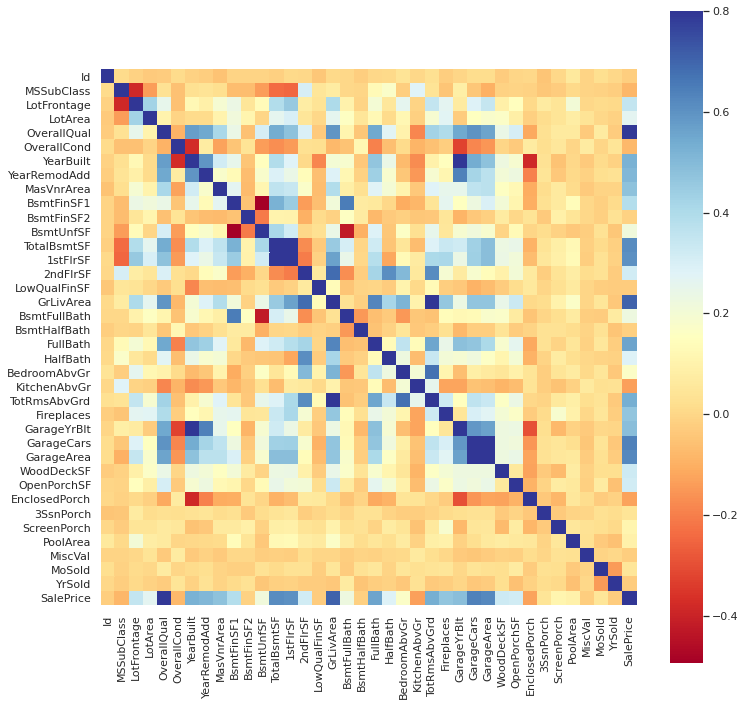

In [6]:
corr_matrix =  train.corr()
sns.set(rc = {'axes.facecolor':'white', 'figure.facecolor':'white'})
f, ax  = plt.subplots(figsize= (12, 12))
sns.heatmap(corr_matrix, vmax = .8, square=True, cmap="RdYlBu")

####  Top 10 positively corelated features with 'SalePrice'

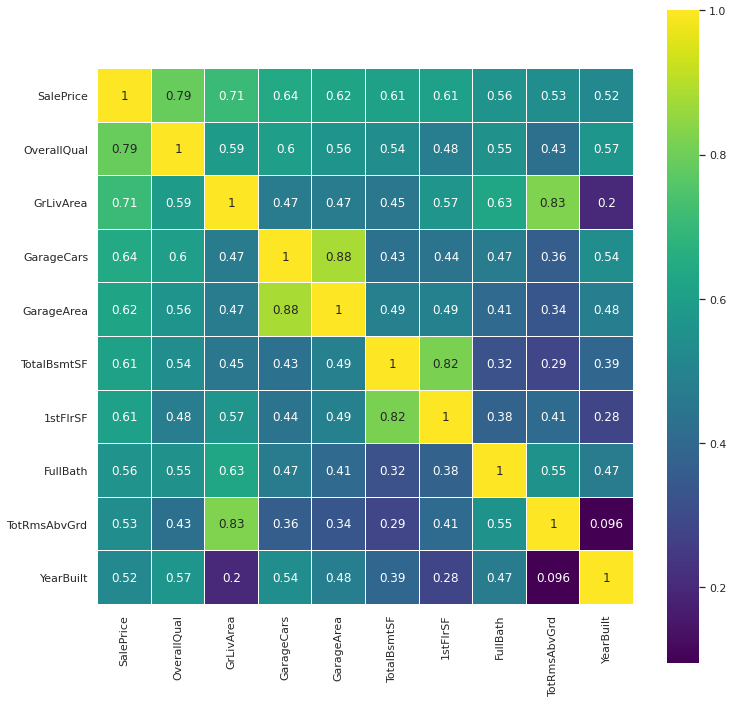

In [7]:
k = 10
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
f , ax = plt.subplots(figsize = (12,12))
hmm = sns.heatmap(cm,linewidths=0.01, annot=True, cmap = 'viridis', annot_kws={'size': 12}, square=True, xticklabels=cols.values, yticklabels = cols.values)
plt.show()

#### Observations
1. 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
2. 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However we know that the number of cars that fit into the garage is a consequence of the garage area.Therefore, we just need one of these variables in our analysis. We can keep 'GarageCars' since its correlation with 'SalePrice' is higher.

####  Top 10 negatively correlated features with 'SalePrice'

Index(['SalePrice', 'KitchenAbvGr', 'EnclosedPorch', 'MSSubClass',
       'OverallCond', 'YrSold', 'LowQualFinSF', 'Id', 'MiscVal',
       'BsmtHalfBath', 'BsmtFinSF2'],
      dtype='object')


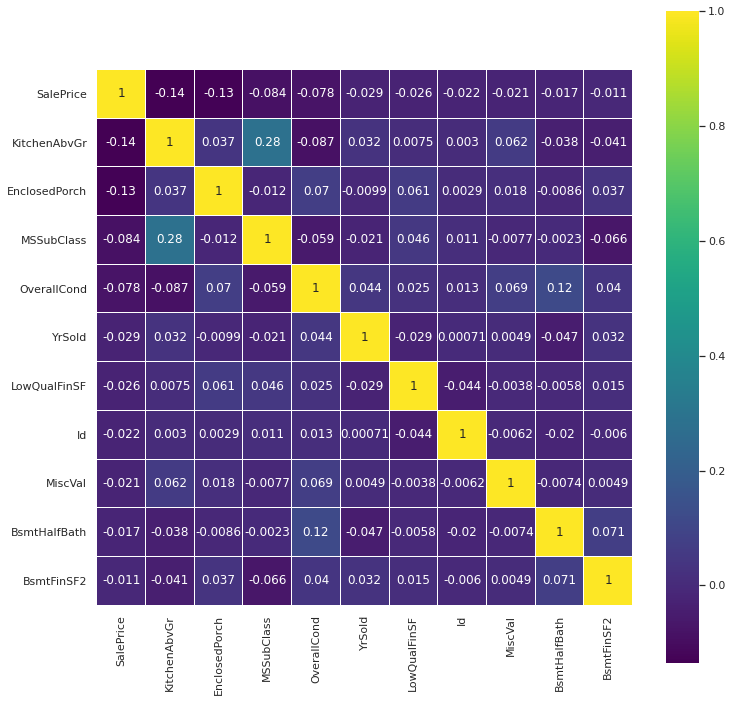

In [8]:
k = 10
cols = corr_matrix.nlargest(1,'SalePrice')['SalePrice'].append(corr_matrix.nsmallest(k,'SalePrice')['SalePrice'])
cols_index = cols.index
print(cols_index)
cm = np.corrcoef(train[cols_index].values.T)
f , ax = plt.subplots(figsize = (12,12))
hmm = sns.heatmap(cm,linewidths=0.01, annot=True, cmap = 'viridis', annot_kws={'size': 12}, square=True,xticklabels=cols_index.values, yticklabels = cols_index.values)
plt.show()

In [9]:
attrs = corr_matrix.iloc[:-1,:-1] # all except target
threshold = 0.5

important_corrs = (attrs[abs(attrs) > threshold][attrs != 1.0]).unstack().dropna().to_dict()
unique_important_corrs = pd.DataFrame(list(set([(tuple(sorted(key)), important_corrs[key]) for key in important_corrs])), columns=['Feature_Pair', 'Corr'])

# sorted by absolute value
imp_corr = unique_important_corrs.iloc[abs(unique_important_corrs['Corr']).argsort()[::-1]]
imp_corr


,Feature_Pair,Corr
9,"(GarageArea, GarageCars)",0.882475
20,"(GarageYrBlt, YearBuilt)",0.825667
3,"(GrLivArea, TotRmsAbvGrd)",0.825489
0,"(1stFlrSF, TotalBsmtSF)",0.819530
13,"(2ndFlrSF, GrLivArea)",0.687501
18,"(BedroomAbvGr, TotRmsAbvGrd)",0.676620
6,"(BsmtFinSF1, BsmtFullBath)",0.649212
14,"(GarageYrBlt, YearRemodAdd)",0.642277
12,"(FullBath, GrLivArea)",0.630012
26,"(2ndFlrSF, TotRmsAbvGrd)",0.616423


#### Here we are trying to show the multicollinearity. In regression, multicollinearity refers to features that are coorelated with other features. Multicollonearity occurs when your model includes multiple factors that are coorrelated to each other as well and not just to your target variable.

Problem:
Multicollinearity increases the standard errors of the cooefficients. That means, multicollinearity makes some variables statistically insignificant when they should be significant.

To Avoid:
1. Completely remove those variables
2. Make new features by adding them or by some other operation.
3. Use PCA, which will reduce feature set to small number of non-collinear feature

In [10]:
#coorelation with our target Variable - SalePrice
corr_matrix['SalePrice']

Id              -0.021917
MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePr

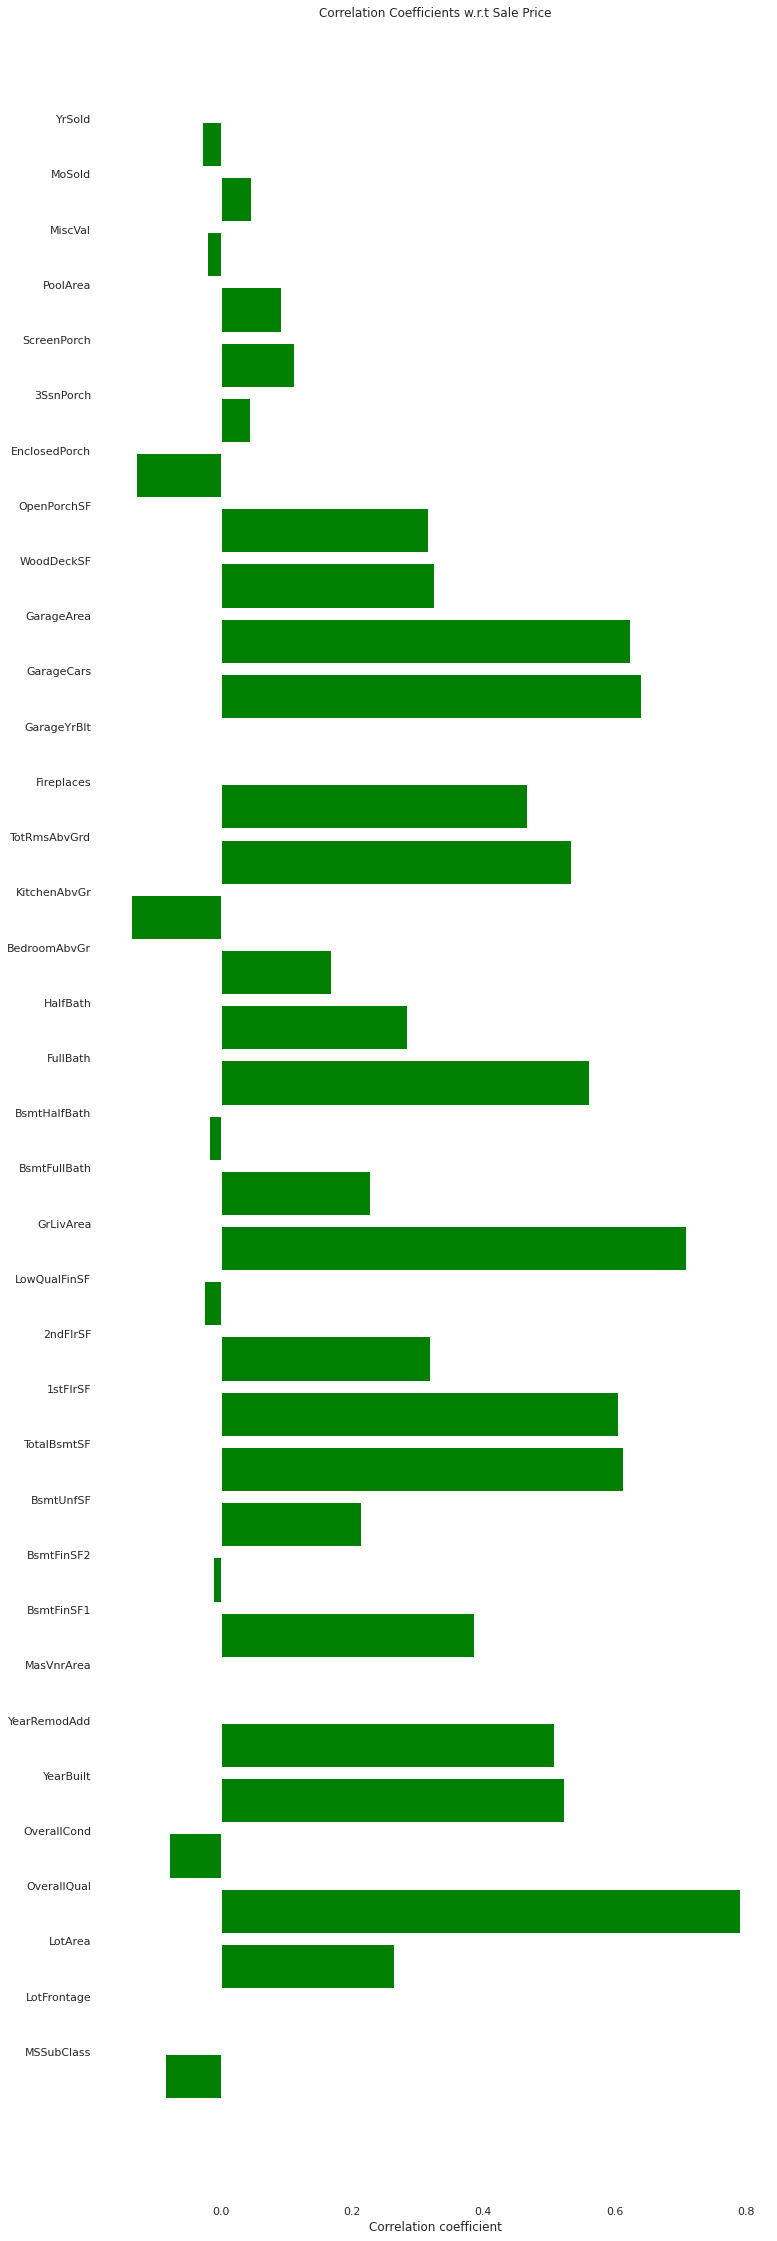

In [11]:
num_feat = train.columns[train.dtypes != object]
num_feat = num_feat[1:-1]
labels = []
values = []
for col in num_feat:
    labels.append(col)
    values.append(np.corrcoef(train[col].values, train.SalePrice.values)[0,1])
    
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(values), color='green')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients w.r.t Sale Price");

#### Observations from Correlation plot
- OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbcGrd, YearBuilt, YearRemodAdd have positive correlation with SalePrice (> 0.5)
- EnclosedPorch and KitchenAbvGr have negative correlation with target Variable
- These features can prove to be important features to predict SalePrice.

####  Interesting Plot

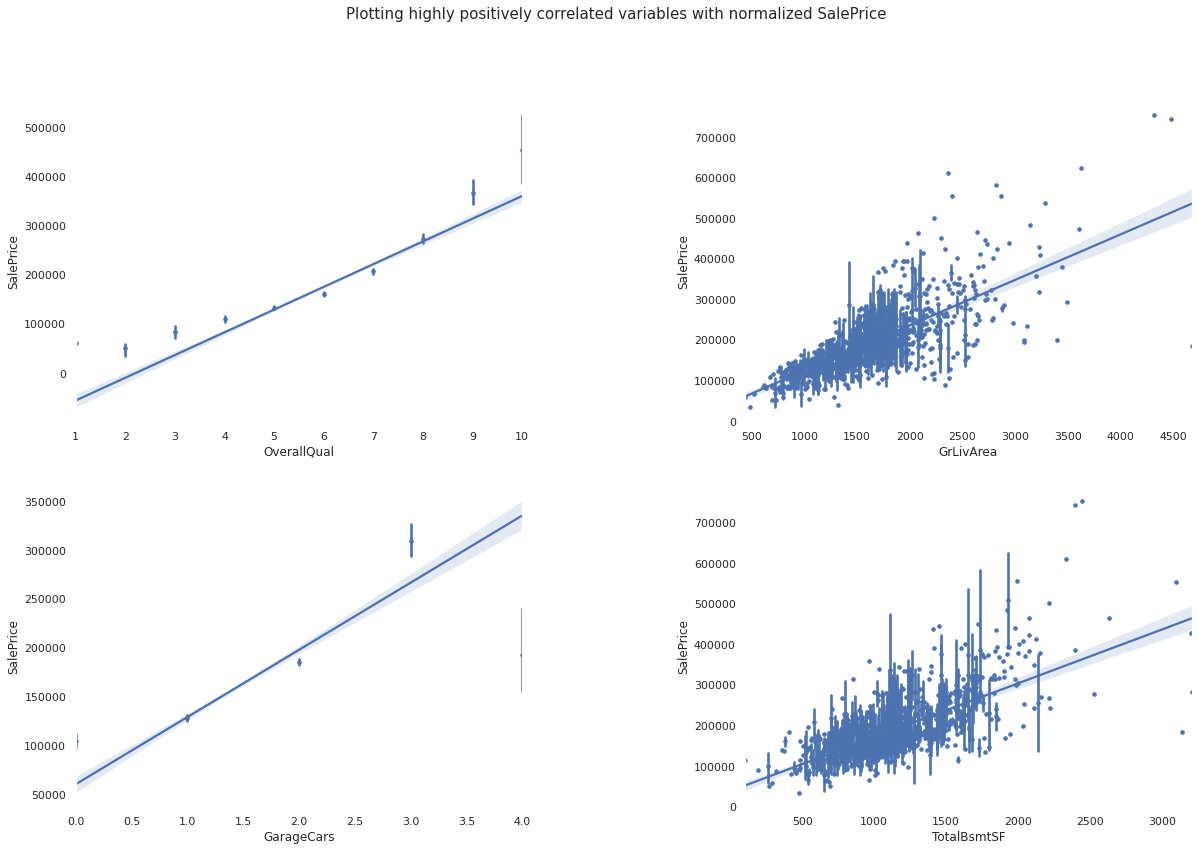

In [12]:
train_scatter = train.copy()
train_scatter = train_scatter.loc[train_scatter['TotalBsmtSF']<3500.0]
train_scatter = train_scatter.loc[train_scatter['TotalBsmtSF']>0.0]

def plot_scatter(features,title):
    fig, (axs,axs1) = plt.subplots(nrows=2, ncols=2, figsize=(20,13))
    fig.subplots_adjust(wspace=0.5)
    for i in range(0,len(features)):
        plot = pd.concat([train_scatter['SalePrice'],train_scatter[features[i]]],axis = 1)
        if i<2 :
            g = sns.regplot(x=features[i],y = 'SalePrice',data = plot,scatter= True,
                      truncate=True,x_estimator=np.mean,marker='.',
                      fit_reg=True,ax=axs[i])
        else:
            g = sns.regplot(x=features[i],y = 'SalePrice',data = plot,scatter= True,
                      truncate=True,x_estimator=np.mean,marker='.',
                      fit_reg=True,ax=axs1[i-2])
        fig.suptitle("Plotting highly "+title+"ly correlated variables with normalized SalePrice",fontsize="15")
        if title=='negative':
            g.set(xticklabels=feat_labels[features[i]])
  
pos_features =['OverallQual','GrLivArea','GarageCars','TotalBsmtSF']
plot_scatter(pos_features,'positive')

del train_scatter

# Missing Values Analysis

In [13]:
print("Missing Value Counts in Training Data")
train.isna().sum()[train.isna().sum()>0].sort_values(ascending=False)

Missing Value Counts in Training Data


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [14]:
print("Missing Values in Test Data")
test.isna().sum()[test.isna().sum()>0].sort_values(ascending=False)

Missing Values in Test Data


PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

# Feature Engineering

In [15]:
train.fillna(train.mean(), inplace=True)
TotalBsmtSFMean = train['TotalBsmtSF'].mean()
train.loc[train['TotalBsmtSF'] == 0, 'TotalBsmtSF'] = np.round(TotalBsmtSFMean).astype(int)

test.fillna(test.mean(), inplace=True)
TTotalBsmtSFMean = test['TotalBsmtSF'].mean()
test.loc[test['TotalBsmtSF'] == 0, 'TotalBsmtSF'] = np.round(TotalBsmtSFMean).astype(int)

y = train['SalePrice']
train = train.drop('SalePrice', axis=1)
X = train
tX = test

train_num = len(X)
dataset = pd.concat(objs=[X, tX], axis=0)

#log transform skewed numeric features:
numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

dataset[skewed_feats] = np.log1p(dataset[skewed_feats])

dataset_preprocessed = pd.get_dummies(dataset)
train_preprocessed = dataset_preprocessed[:train_num]
test_preprocessed = dataset_preprocessed[train_num:]


#### We tried different ranges of n_estimators for the RandomForrestRegressor to get the n_estimator value for least RMSE value

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_preprocessed, y, test_size=0.3, random_state=0)

rmse_est = {}
for est in range(360,550,20):
    model = RandomForestRegressor(n_estimators=est, n_jobs=-1)
    model.fit(X_train, y_train)
    predictions = np.array(model.predict(X_test))
    rmse = math.sqrt(np.mean((np.array(y_test) - predictions)**2))
    imp = sorted(zip(X.columns, model.feature_importances_), key=lambda tup: tup[1], reverse=True)
    print ("RMSE: {0} - est: {1}".format(str(rmse), est))
    rmse_est[rmse]= est

d = collections.OrderedDict(sorted(rmse_est.items()))

RMSE: 30936.719538751575 - est: 360
RMSE: 31326.824717384494 - est: 380
RMSE: 31202.660077031935 - est: 400
RMSE: 31078.68504287539 - est: 420
RMSE: 31044.238151274447 - est: 440
RMSE: 31233.360427073938 - est: 460
RMSE: 31066.57956169002 - est: 480
RMSE: 30952.36294872532 - est: 500
RMSE: 30983.19057097819 - est: 520
RMSE: 31275.965023733206 - est: 540


In [21]:
cv = KFold(n_splits=5, random_state=random_state)
model = RandomForestRegressor(n_estimators=list(d.items())[0][1], n_jobs=-1)
model_scores = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1)
model.fit(train_preprocessed, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=360, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [23]:
model_scores

array([0.79400648, 0.87720738, 0.85317848, 0.84346962, 0.88448997])

In [18]:
pred = model.predict(test_preprocessed)
submission = pd.DataFrame({"Id": test_preprocessed["Id"],"SalePrice": pred})
submission.loc[submission['SalePrice'] <= 0, 'SalePrice'] = 0
fileName = "submission.csv".format(rmse)
submission.to_csv(fileName, index=False)